# Using surveillance data to investigate chlamydia prevalence

This example illustrates the theoretical results in the parent folder. It uses surveillance data on chlamydia testing and diagnosis rates in England in 2012 available at: http://www.chlamydiascreening.nhs.uk/ps/data.asp (downloaded 17 April 2015). Data on the proportion of men and women sexually active comes from Natsal-2. (Note that no 15-year-olds are included in Natsal-2.) Begin by considering the nation as a whole:

|      | Men (15-24 years old)  | Women (15-24 years old) |
|------|------|-------|
|Proportion sexually active: numerator | 1071 (weighted: 1307.6511)| 1239 (weighted: 1255.6630)|
|Proportion sexually active: denominator | 1353 (weighted: 1630.126)| 1558 (weighted: 1534.735)|
|Population | 3519015| 3388842 |
|Tests      |566908 | 1205896 |
|Diagnoses  |48387  | 88101 |

In [1]:
from numpy import *
from scipy.stats import beta
from scipy.optimize import fsolve

# men, 16-19
print fsolve(
    lambda x: array(beta.interval(0.95, x[0], x[1], loc=0, scale=1))
    - (0.6747424, 0.741327698),
    [1,1]
    )

# men, 20-24
print fsolve(
    lambda x: array(beta.interval(0.95, x[0], x[1], loc=0, scale=1))
    - (0.8844970, 0.933759842),
    [1,1]
    )

# women, 16-19
print fsolve(
    lambda x: array(beta.interval(0.95, x[0], x[1], loc=0, scale=1))
    - (0.6583593, 0.723554878),
    [1,1]
    )

# women, 20-24
print fsolve(
    lambda x: array(beta.interval(0.95, x[0], x[1], loc=0, scale=1))
    - (0.8904135, 0.934417684),
    [1,1]
    )


[ 505.98795355  208.09085642]
[ 466.55519199   45.77961509]
[ 532.23142129  237.52519958]
[ 569.18290127   53.77883386]


In [2]:
from scipy.stats import gamma
from numpy.random import normal

n_sample = 10000

# sexually-active population:
p_active_m_16_19 = random.beta(505.98795355, 208.09085642, size=n_sample) # 16-19 yo only
pop_active_m_15_19 = random.binomial(1685620, p_active_m_16_19, size=n_sample)

p_active_m_20_24 = random.beta(466.55519199, 45.77961509, size=n_sample) # 20-24 yo only
pop_active_m_20_24 = random.binomial(1833395, p_active_m_20_24, size=n_sample)

p_active_f_16_19 = random.beta(532.23142129, 237.52519958, size=n_sample) # 16-19 yo only
pop_active_f_15_19 = random.binomial(1600686, p_active_f_16_19, size=n_sample)
p_active_f_20_24 = random.beta(569.18290127, 53.77883386, size=n_sample) # 20-24 yo only
pop_active_f_20_24 = random.binomial(1788156, p_active_f_20_24, size=n_sample)

# data in men: testing and diagnosis rates, per person per year
diag_rate_m_15_19 = random.gamma(15213, 1, size=n_sample)/pop_active_m_15_19
diag_rate_m_20_24 = random.gamma(33174, 1, size=n_sample)/pop_active_m_20_24
test_rate_m_15_19 = random.gamma(232668, 1, size=n_sample)/pop_active_m_15_19
test_rate_m_20_24 = random.gamma(334240, 1, size=n_sample)/pop_active_m_20_24
diag_rate_f_15_19 = random.gamma(42874, 1, size=n_sample)/pop_active_f_15_19
diag_rate_f_20_24 = random.gamma(45227, 1, size=n_sample)/pop_active_f_20_24
test_rate_f_15_19 = random.gamma(520358, 1, size=n_sample)/pop_active_f_15_19
test_rate_f_20_24 = random.gamma(685538, 1, size=n_sample)/pop_active_f_20_24

# proportion of incident infections asymptomatic is not known, and 
# proportion of prevalent infections asymptomatic would depend on the screening programme.
# for the moment, assume
p_asymp_m = random.beta(69 + 1, 78 - 69 + 1, size=n_sample) # Mackay et al. Lancet 361 (2003) 88% NB this is an upper bound, as relates to the proportion of prevalent - not incident - infections
p_asymp_f = random.beta(163 + 1, 185 - 163 + 1, size=n_sample) # Kahn et al. STDs (2003) 88% NB this is an upper bound, as relates to the proportion of prevalent - not incident - infections. It's also from the US, and the % reported in the paper doesn't give a whole number of patients..

# test performance
p_true_pos_m = random.beta(32+1, 0+1, size=n_sample) # Horner J. Clin. Microbiol (2005): 32 of 32 infected samples tested +ve
p_false_pos_m = random.beta(2+1, 950+1, size=n_sample) # Horner J. Clin. Microbiol (2005): 2 of 952 uninfected samples tested +ve
p_true_pos_f = random.beta(129+1, 12+1, size=n_sample) # Low Health Technol Assess (2007): 129 of 141 infected samples tested +ve
p_false_pos_f = random.beta(4+1, 2323+1, size=n_sample) # Low Health Technol Assess (2007): 4 of 2327 uninfected samples tested +ve


In [3]:
# Metropolis-Hastings to get a sample for rate of treatment, given symptoms
# assuming a constant hazard of attending beginning at the onset of symptoms
# Don't have separate data for men and women here.

%run multinomial_pmf.py

i = 0
att_symp = empty(n_sample) # testing rate per person per year
old = 13 # starting sample value
new = 13 # starting sample value
# simulate probabilities corresponding to Mercer data
simp_new = append((1 - exp(-array([7,14,28,42])*new/365.25)),1) - (1 - exp(-array([0,7,14,28,42])*new/365.25)) 

acc=0.
while i < n_sample: # to do samples for p_test_symp
    
    new = random.normal(old, 1.5) # generate a sample from normal distribution
    
    if new < 0:
        att_symp[i] = old # reject
    else:
        simp_old = append((1 - exp(-array([7,14,28,42])*old/365.25)),1) - (1 - exp(-array([0,7,14,28,42])*old/365.25)) # simulate probabilities corresponding to the Mercer data
        simp_new = append((1 - exp(-array([7,14,28,42])*new/365.25)),1) - (1 - exp(-array([0,7,14,28,42])*new/365.25)) # simulate probabilities corresponding to the Mercer data

        if sum(simp_new >0) != 5:
            att_symp[i] = old # reject
        else:
            m_old = Multinomial(simp_old)
            m_new = Multinomial(simp_new)

            # simulate probabilities corresponding to the Mercer Sex. Transm. Dis. 2007
            # nb would be best to get raw data from them
            log_ratio = m_new.log_pmf([245, 132, 191, 152, 196]) - m_old.log_pmf([245, 132, 191, 152, 196])
    
            if log(random.uniform(0,1)) <  log_ratio: #/beta.pdf(sample, 4, 83) ):
                att_symp[i] = old # reject
                old = new
                acc = acc+1
            else:
                att_symp[i] = new # reject
        
    i = i+1
    
print acc/n_sample


0.3714


13.443841273175552

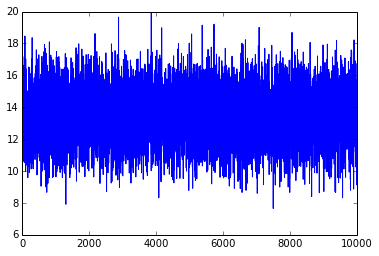

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(att_symp)
mean(att_symp)

In [5]:
# Metropolis-Hastings to get a sample for rate of spontaneous clearance in women
# assuming a constant hazard of recovery
# use Joyner STDs 2002

i = 0
sc_f = empty(n_sample) # testing rate per person per year
old = 1 # starting sample value
new = 1 # starting sample value
# simulate probabilities corresponding to Joyner data
simp_new = append((1 - exp(-array([7,14,21,42,112])*new/365.25)),1) - (1 - exp(-array([2,7,14,21,42,112])*new/365.25)) 

acc=0.
while i < n_sample: # to do samples for p_test_symp
    
    new = random.normal(old, 1) # generate a sample from normal distribution
    
    if new < 0:
        sc_f[i] = old # reject
    else:
        simp_old = append((1 - exp(-array([7,14,21,42,112])*old/365.25)),1) - (1 - exp(-array([2,7,14,21,42,112])*old/365.25)) # simulate probabilities corresponding to the Mercer data
        simp_new = append((1 - exp(-array([7,14,21,42,112])*new/365.25)),1) - (1 - exp(-array([2,7,14,21,42,112])*new/365.25)) # simulate probabilities corresponding to the Mercer data

        
        if sum(simp_new >0) != 6:
            sc_f[i] = old # reject
        else:
            f_old = Multinomial(simp_old)
            f_new = Multinomial(simp_new)

            # simulate probabilities 
            log_ratio = f_new.log_pmf([2, 7, 1, 0, 3, 45]) - f_old.log_pmf([2, 7, 1, 0, 3, 45])
    
            if log(random.uniform(0,1)) <  log_ratio: #/beta.pdf(sample, 4, 83) ):
                sc_f[i] = old # reject
                old = new
                acc = acc+1
            else:
                sc_f[i] = new # reject
        
    i = i+1
    
print acc/n_sample



0.2899


In [6]:
# Metropolis-Hastings to get a sample for rate of spontaneous clearance in men
# assuming a constant hazard of recovery
# use Joyner STDs 2002

i = 0
sc_m = empty(n_sample) # testing rate per person per year
old = 1 # starting sample value
new = 1 # starting sample value
# simulate probabilities corresponding to Joyner data
simp_new = append((1 - exp(-array([7,14,21,42,112])*new/365.25)),1) - (1 - exp(-array([2,7,14,21,42,112])*new/365.25)) 

acc=0.
while i < n_sample: # to do samples for p_test_symp
    
    new = random.normal(old, 1) # generate a sample from normal distribution
    
    if new < 0:
        sc_m[i] = old # reject
    else:
        simp_old = append((1 - exp(-array([7,14,21,42,112])*old/365.25)),1) - (1 - exp(-array([2,7,14,21,42,112])*old/365.25)) # simulate probabilities corresponding to the Mercer data
        simp_new = append((1 - exp(-array([7,14,21,42,112])*new/365.25)),1) - (1 - exp(-array([2,7,14,21,42,112])*new/365.25)) # simulate probabilities corresponding to the Mercer data

        
        if sum(simp_new >0) != 6:
            sc_m[i] = old # reject
        else:
            m_old = Multinomial(simp_old)
            m_new = Multinomial(simp_new)

            # simulate probabilities 
            log_ratio = m_new.log_pmf([3,2,1,0,1,29]) - m_old.log_pmf([3,2,1,0,1,29])
    
            if log(random.uniform(0,1)) <  log_ratio: #/beta.pdf(sample, 4, 83) ):
                sc_m[i] = old # reject
                old = new
                acc = acc+1
            else:
                sc_m[i] = new # reject
        
    i = i+1
    
print acc/n_sample



0.3337


1.10960554269
1.21279618745


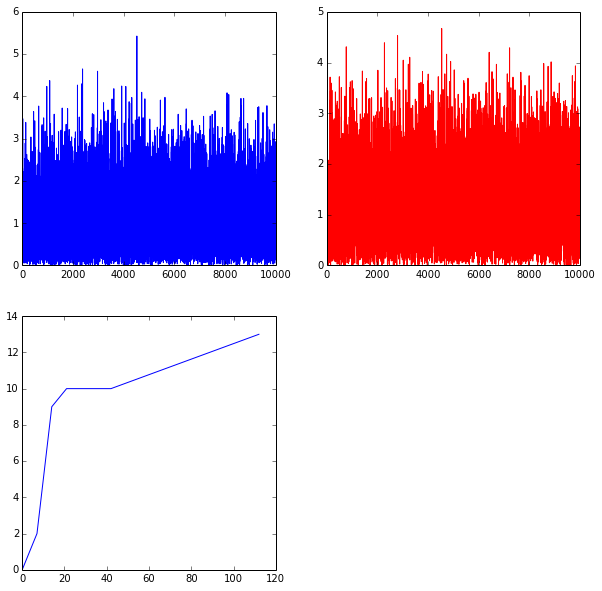

In [7]:
fig = plt.figure(figsize = (10,10))
ax1 = fig.add_subplot(221)
ax1.plot(sc_m)
ax2 = fig.add_subplot(222)
ax2.plot(sc_f,'r')
ax3 = fig.add_subplot(223)
ax3.plot([0,7,14,21,42,112],[0,2,9,10,10,13])
# a rate of 1.5 year^-1 corresponds to average recovery time of about 35 weeks.
print mean(sc_m)
print mean(sc_f)

In [9]:
# now use these samples to try and infer prevalence in men and women
# this script contains the functions for three-part observations (tests, symptomatic diagnoses, asymptomatic diagnoses) too
# running this script takes a little while because of all the symbolic algebra
%run test_diag_fun.py

from numpy import *
from scipy.optimize import fsolve

In [10]:
# men first...
prev_m_15_19 = zeros(n_sample)
inc_m_15_19 = zeros(n_sample)
scr_m_15_19 = zeros(n_sample)

for i in xrange(n_sample):
    [inc_m_15_19[i], scr_m_15_19[i]] = fsolve(lambda x: test_diag_fun(concatenate([
                    x, array([
                            1-p_asymp_m[i], # proportion of incident infections which are symptomatic
                            sc_m[i], # rate of self-clear 
                            att_symp[i],
                            p_true_pos_m[i], 
                            p_false_pos_m[i]
                        ])])) - array([test_rate_m_15_19[i],diag_rate_m_15_19[i]]), [0.09, 0.25])
    prev_m_15_19[i] = dyn_fun(inc_m_15_19[i]*p_asymp_m[i], sc_m[i] + scr_m_15_19[i]*p_true_pos_m[i], inc_m_15_19[i]*(1-p_asymp_m[i]), sc_m[i] + att_symp[i]*p_true_pos_m[i])

In [11]:
prev_m_20_24 = zeros(n_sample)
inc_m_20_24 = zeros(n_sample)
scr_m_20_24 = zeros(n_sample)

for i in xrange(n_sample):
    [inc_m_20_24[i], scr_m_20_24[i]] = fsolve(lambda x: test_diag_fun(concatenate([
                    x, array([
                            1-p_asymp_m[i], # proportion of incident infections which are symptomatic
                            sc_m[i], # rate of self-clear 
                            att_symp[i],
                            p_true_pos_m[i], 
                            p_false_pos_m[i]
                        ])])) - array([test_rate_m_20_24[i],diag_rate_m_20_24[i]]), [0.09, 0.25])
    prev_m_20_24[i] = dyn_fun(inc_m_20_24[i]*p_asymp_m[i], sc_m[i] + scr_m_20_24[i]*p_true_pos_m[i], inc_m_20_24[i]*(1-p_asymp_m[i]), sc_m[i] + att_symp[i]*p_true_pos_m[i])

In [12]:
# ... then women
prev_f_15_19 = zeros(n_sample)
inc_f_15_19 = zeros(n_sample)
scr_f_15_19 = zeros(n_sample)

for i in xrange(n_sample):
    [inc_f_15_19[i], scr_f_15_19[i]] = fsolve(lambda x: test_diag_fun(concatenate([
                    x, array([
                            1-p_asymp_f[i], # proportion of incident infections which are symptomatic
                            sc_f[i], # rate of self-clear 
                            att_symp[i],
                            p_true_pos_f[i], 
                            p_false_pos_f[i]
                        ])])) - array([test_rate_f_15_19[i],diag_rate_f_15_19[i]]), [0.03, 0.44])
    prev_f_15_19[i] = dyn_fun(inc_f_15_19[i]*p_asymp_f[i], sc_f[i] + scr_f_15_19[i]*p_true_pos_f[i], inc_f_15_19[i]*(1-p_asymp_f[i]), sc_f[i] + att_symp[i]*p_true_pos_f[i])

In [13]:
# ... then women
prev_f_20_24 = zeros(n_sample)
inc_f_20_24 = zeros(n_sample)
scr_f_20_24 = zeros(n_sample)

for i in xrange(n_sample):
    [inc_f_20_24[i], scr_f_20_24[i]] = fsolve(lambda x: test_diag_fun(concatenate([
                    x, array([
                            1-p_asymp_f[i], # proportion of incident infections which are symptomatic
                            sc_f[i], # rate of self-clear 
                            att_symp[i],
                            p_true_pos_f[i], 
                            p_false_pos_f[i]
                        ])])) - array([test_rate_f_20_24[i],diag_rate_f_20_24[i]]), [0.03, 0.44])
    prev_f_20_24[i] = dyn_fun(inc_f_20_24[i]*p_asymp_f[i], sc_f[i] + scr_f_20_24[i]*p_true_pos_f[i], inc_f_20_24[i]*(1-p_asymp_f[i]), sc_f[i] + att_symp[i]*p_true_pos_f[i])

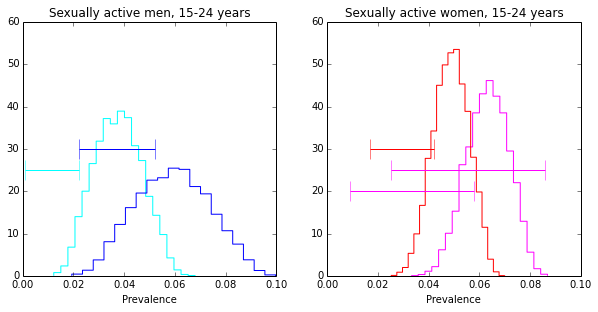

In [14]:
fig = plt.figure(figsize = (10,10))

ax1 = fig.add_subplot(221)
h_2012_m_15_19 = ax1.hist(prev_m_15_19, bins=20, normed=true, histtype='step', color='cyan')
h_2012_m_20_24 = ax1.hist(prev_m_20_24, bins=20, normed=true, histtype='step', color='blue')
#ax1.fill_betweenx([0,100], percentile(prev_m15_19, 2.5), percentile(prev_m15_19, 97.5), facecolor='b', alpha=0.5)
ax1.errorbar(0.001, 25, xerr=[[0],[0.022-0.001]], ecolor='cyan', capsize=10)
ax1.errorbar(0.022, 30, xerr=[[0],[0.052-0.022]], ecolor='blue', capsize=10)
ax1.set_xlabel('Prevalence')
ax1.set_xlim(0,0.1)
ax1.set_ylim(0,60)
ax1.set_title('Sexually active men, 15-24 years')

ax2 = fig.add_subplot(222)
h_2012_f_15_19 = ax2.hist(prev_f_15_19, range=[min(prev_f_15_19),max(prev_f_15_19)], bins=20, normed=true, histtype='step', color='fuchsia')
h_2012_f_20_24 = ax2.hist(prev_f_20_24, range=[min(prev_f_20_24),max(prev_f_20_24)], bins=20, normed=true, histtype='step', color='r')
#ax2.fill_betweenx([0,100], percentile(prev_f, 2.5), percentile(prev_f, 97.5), facecolor='r', alpha=0.5)
ax2.errorbar(0.009, 20, xerr=[[0],[0.058-0.009]], ecolor='fuchsia', capsize=10)
ax2.errorbar(0.025, 25, xerr=[[0],[0.086-0.025]], ecolor='fuchsia', capsize=10)
ax2.errorbar(0.017, 30, xerr=[[0],[0.042-0.017]], ecolor='r', capsize=10)
ax2.set_xlabel('Prevalence')
ax2.set_xlim(0,0.1)
ax2.set_ylim(0,60)
ax2.set_title('Sexually active women, 15-24 years')

# ax3 = fig.add_subplot(223)
# ax3.fill_betweenx([0,1], percentile(inc_m, 2.5), percentile(inc_m, 97.5), facecolor='b', alpha=0.5)
# ax3.fill_between([0,1], percentile(scr_m, 2.5), percentile(scr_m, 97.5), facecolor='b', alpha=0.5)
# ax3.plot(inc_m, scr_m, '.', markersize=1)
# ax3.set_xlim([0,0.3])
# ax3.set_ylim([0,0.47])
# ax3.set_xlabel('Incidence')
# ax3.set_ylabel('Screening')

# ax4 = fig.add_subplot(224)
# ax4.fill_betweenx([0,1], percentile(inc_f, 2.5), percentile(inc_f, 97.5), facecolor='r', alpha=0.5)
# ax4.fill_between([0,1], percentile(scr_f, 2.5), percentile(scr_f, 97.5), facecolor='r', alpha=0.5)
# ax4.plot(inc_f, scr_f, '.r', markersize=1)
# ax4.set_xlim([0,0.3])
# ax4.set_ylim([0,0.47])
# ax4.set_xlabel('Incidence')
# ax4.set_ylabel('Screening')


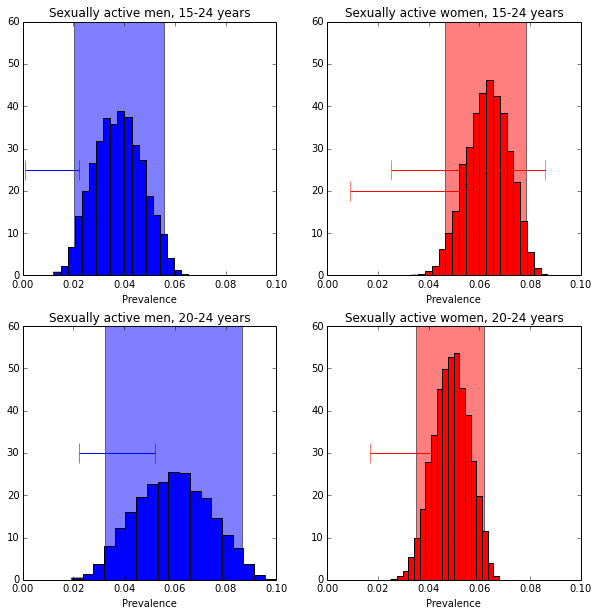

In [15]:
fig = plt.figure(figsize = (10,10))

ax1 = fig.add_subplot(221)
h_2012_m_15_19 = ax1.hist(prev_m_15_19, bins=20, normed=true, color='b')
ax1.fill_betweenx([0,100], percentile(prev_m_15_19, 2.5), percentile(prev_m_15_19, 97.5), facecolor='b', alpha=0.5)
ax1.errorbar(0.001, 25, xerr=[[0],[0.022-0.001]], ecolor='b', capsize=10)
ax1.set_xlabel('Prevalence')
ax1.set_xlim(0,0.1)
ax1.set_ylim(0,60)
ax1.set_title('Sexually active men, 15-24 years')

ax2 = fig.add_subplot(222)
h_2012_f_15_19 = ax2.hist(prev_f_15_19, range=[min(prev_f_15_19),max(prev_f_15_19)], bins=20, normed=true, color='r')
ax2.fill_betweenx([0,100], percentile(prev_f_15_19, 2.5), percentile(prev_f_15_19, 97.5), facecolor='r', alpha=0.5)
ax2.errorbar(0.009, 20, xerr=[[0],[0.058-0.009]], ecolor='r', capsize=10)
ax2.errorbar(0.025, 25, xerr=[[0],[0.086-0.025]], ecolor='r', capsize=10)
ax2.set_xlabel('Prevalence')
ax2.set_xlim(0,0.1)
ax2.set_ylim(0,60)
ax2.set_title('Sexually active women, 15-24 years')

ax3 = fig.add_subplot(223)
h_2012_m_20_24 = ax3.hist(prev_m_20_24, bins=20, normed=true, color='blue')
ax3.fill_betweenx([0,100], percentile(prev_m_20_24, 2.5), percentile(prev_m_20_24, 97.5), facecolor='b', alpha=0.5)
ax3.errorbar(0.022, 30, xerr=[[0],[0.052-0.022]], ecolor='blue', capsize=10)
ax3.set_xlabel('Prevalence')
ax3.set_xlim(0,0.1)
ax3.set_ylim(0,60)
ax3.set_title('Sexually active men, 20-24 years')

ax4 = fig.add_subplot(224)
h_2012_f_20_24 = ax4.hist(prev_f_20_24, range=[min(prev_f_20_24),max(prev_f_20_24)], bins=20, normed=true, color='r')
ax4.fill_betweenx([0,100], percentile(prev_f_20_24, 2.5), percentile(prev_f_20_24, 97.5), facecolor='r', alpha=0.5)
ax4.errorbar(0.017, 30, xerr=[[0],[0.042-0.017]], ecolor='r', capsize=10)
ax4.set_xlabel('Prevalence')
ax4.set_xlim(0,0.1)
ax4.set_ylim(0,60)
ax4.set_title('Sexually active women, 20-24 years')


Although the data does not report the number of diagnoses that were in symptomatic and asymptomatic cases, we can examine the inferences which would have followed in different situations.

In [16]:
# # data in men: testing and diagnosis rates, per person per year
# diag_rate_m_15_19 = random.gamma(15213, 1, size=n_sample)/pop_active_m_15_19
# diag_rate_m_20_24 = random.gamma(33174, 1, size=n_sample)/pop_active_m_20_24
# test_rate_m_15_19 = random.gamma(232668, 1, size=n_sample)/pop_active_m_15_19
# test_rate_m_20_24 = random.gamma(334240, 1, size=n_sample)/pop_active_m_20_24
# diag_rate_f_15_19 = random.gamma(42874, 1, size=n_sample)/pop_active_f_15_19
# diag_rate_f_20_24 = random.gamma(45227, 1, size=n_sample)/pop_active_f_20_24
# test_rate_f_15_19 = random.gamma(520358, 1, size=n_sample)/pop_active_f_15_19
# test_rate_f_20_24 = random.gamma(685538, 1, size=n_sample)/pop_active_f_20_24


(0, 0.1)

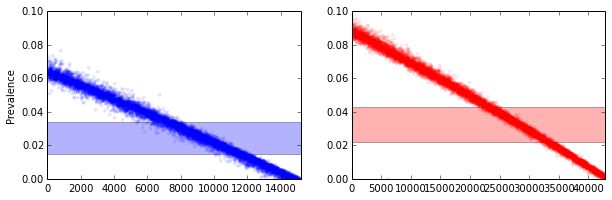

In [44]:
# men first...
prev_m = zeros(n_sample)
inc_m = zeros(n_sample)
scr_m = zeros(n_sample)
p_symp_m = zeros(n_sample)

# don't allow all symptomatic or all asymptomatic - messes with gamma distributions
sample_symp = ceil(15212*random.uniform(size = n_sample))
diag_rate_symp_m_15_19 = random.gamma(sample_symp, 1, size=n_sample)/pop_active_m_15_19

sample_asymp = 15213 - sample_symp
diag_rate_asymp_m_15_19 = random.gamma(sample_asymp, 1, size=n_sample)/pop_active_m_15_19

for i in xrange(n_sample):
    [inc_m[i], scr_m[i], p_symp_m[i]] = fsolve(lambda x: test_diag_sym_asym_fun(concatenate([
                    x, array([
                            sc_m[i], # rate of self-clear 
                            att_symp[i],
                            p_true_pos_m[i], 
                            p_false_pos_m[i]
                        ])])) - array([test_rate_m_15_19[i],diag_rate_symp_m_15_19[i],diag_rate_asymp_m_15_19[i]]), 
                                               [0.09, 0.1, 0.1])
    prev_m[i] = dyn_fun(inc_m[i]*(1-p_symp_m[i]), sc_m[i] + scr_m[i]*p_true_pos_m[i], inc_m[i]*p_symp_m[i], sc_m[i] + att_symp[i]*p_true_pos_m[i])

# ... then women
prev_f = zeros(n_sample)
inc_f = zeros(n_sample)
scr_f = zeros(n_sample)
p_symp_f = zeros(n_sample)

# don't allow all symptomatic or all asymptomatic - messes with gamma distributions
sample_symp_f = ceil(42873*random.uniform(size = n_sample))
diag_rate_symp_f_15_19 = random.gamma(sample_symp_f, 1, size=n_sample)/pop_active_f_15_19

sample_asymp_f = 42874 - sample_symp_f
diag_rate_asymp_f_15_19 = random.gamma(sample_asymp_f, 1, size=n_sample)/pop_active_f_15_19

for i in xrange(n_sample):
    [inc_f[i], scr_f[i], p_symp_f[i]] = fsolve(lambda x: test_diag_sym_asym_fun(concatenate([
                    x, array([
                            sc_f[i], # rate of self-clear 
                            att_symp[i],
                            p_true_pos_f[i], 
                            p_false_pos_f[i]
                        ])])) - array([test_rate_f_15_19[i],diag_rate_symp_f_15_19[i],diag_rate_asymp_f_15_19[i]]), 
                                               [0.09, 0.1, 0.1])
    prev_f[i] = dyn_fun(inc_f[i]*(1-p_symp_f[i]), sc_f[i] + scr_f[i]*p_true_pos_f[i], inc_f[i]*p_symp_f[i], sc_f[i] + att_symp[i]*p_true_pos_f[i])

    
fig = plt.figure(figsize = (10,3))

ax1 = fig.add_subplot(121)
ax1.plot(sample_symp, prev_m, '.', alpha = 0.1)
ax1.fill_between([0,20000], 0.015, 0.034, facecolor='b', alpha=0.3)
ax1.set_xlim([0,15213])
ax1.set_ylim([0,0.1])
#ax1.text(0.34, 0.062, '20-24 years', rotation = 'vertical', ha='center', va='bottom')
#ax1.set_title('Sexually active men, 15-24 years')
ax1.set_ylabel('Prevalence')

ax2 = fig.add_subplot(122)
ax2.plot(sample_symp_f, prev_f, '.r', alpha = 0.1)
ax2.fill_between([0,45000], 0.022, 0.043, facecolor='r', alpha=0.3)
ax2.set_xlim([0,42874])
ax2.set_ylim([0,0.1])
#ax2.text(0.34, 0.052, '20-24 years', rotation = 'vertical', ha='center', va='bottom')
#ax2.set_title('Sexually active women, 15-24 years')



Inferred prevalence is very sensitive to the proportion of infections which are asymptomatic, especially where this is a large fraction. Thus, if the proportion asymptomatic was overestimated (which it probably was, since treatment seeking generally enriches this proportion in a population), prevalence would also be biased upwards. This may explain the earlier result. Recording the proportion of diagnoses which are symptomatic would constrain this parameter and improve the accuracy of estimates. It may also improve confidence, though this will depend on the exact parameter values.

How would knowing the number of diagnoses which were symptomatic have helped us? Suppose, for example, that we knew that only 8000 of the 48387 diagnoses in men and only 8000 of the 88101 in women were symptomatic. This extra piece of information allows more accurate inference of the incidence, screening and prevalence and also allows us to estimate the proportion of incident infections which are asymptomatic.

In [51]:
# # rates of symptomatic and asymptomatic diagnoses, per person per year (proportion symptomatic is made up..)
# diag_rate_symp_m = random.gamma(20000, 1, size=n_sample)/pop_active_m
# diag_rate_asymp_m = random.gamma(28387, 1, size=n_sample)/pop_active_m

# diag_rate_symp_f = random.gamma(40000, 1, size=n_sample)/pop_active_f
# diag_rate_asymp_f = random.gamma(48101, 1, size=n_sample)/pop_active_f

# rates of symptomatic and asymptomatic diagnoses, per person per year (from below)
# diag_rate_symp_m = random.gamma(0.021*pop_active_m, 1, size=n_sample)/pop_active_m
# diag_rate_asymp_m = random.gamma(0.018*pop_active_m, 1, size=n_sample)/pop_active_m

# diag_rate_symp_f = random.gamma(0.021*pop_active_f, 1, size=n_sample)/pop_active_f
# diag_rate_asymp_f = random.gamma(0.018*pop_active_f, 1, size=n_sample)/pop_active_f

diag_rate_symp_m = diag_rate_m*0.41
diag_rate_asymp_m = diag_rate_m*(1-0.41)

diag_rate_symp_f = diag_rate_f*0.41
diag_rate_asymp_f = diag_rate_f*(1-0.41)

In [52]:
# men first...
prev_m = zeros(n_sample)
inc_m = zeros(n_sample)
prop_asymp_m = zeros(n_sample)
scr_m = zeros(n_sample)

for i in xrange(n_sample):
    [inc_m[i], scr_m[i], prop_asymp_m[i]] = fsolve(lambda x: test_diag_sym_asym_fun(concatenate([
                    x, array([
                            sc_m[i], # rate of self-clear 
                            att_symp[i],
                            p_true_pos_m[i], 
                            p_false_pos_m[i]
                        ])])) - array([test_rate_m[i],diag_rate_symp_m[i],diag_rate_asymp_m[i]]), [0.09, 0.25,0.9])
    prev_m[i] = dyn_fun(inc_m[i]*prop_asymp_m[i], sc_m[i] + scr_m[i]*p_true_pos_m[i], inc_m[i]*(1-prop_asymp_m[i]), sc_m[i] + att_symp[i]*p_true_pos_m[i])

In [53]:
# ...then women
prev_f = zeros(n_sample)
inc_f = zeros(n_sample)
prop_asymp_f = zeros(n_sample)
scr_f = zeros(n_sample)

for i in xrange(n_sample):
    [inc_f[i], scr_f[i], prop_asymp_f[i]] = fsolve(lambda x: test_diag_sym_asym_fun(concatenate([
                    x, array([
                            sc_f[i], # rate of self-clear 
                            att_symp[i],
                            p_true_pos_f[i], 
                            p_false_pos_f[i]
                        ])])) - array([test_rate_f[i],diag_rate_symp_f[i],diag_rate_asymp_m[i]]), [0.09, 0.25,0.99])
    prev_f[i] = dyn_fun(inc_f[i]*prop_asymp_f[i], sc_f[i] + scr_f[i]*p_true_pos_f[i], inc_f[i]*(1-prop_asymp_f[i]), sc_f[i] + att_symp[i]*p_true_pos_f[i])

(0.1, 0.5)

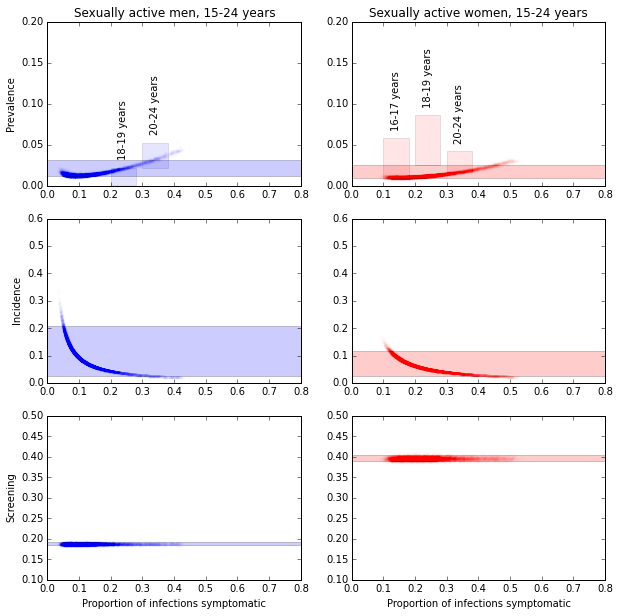

In [54]:
fig = plt.figure(figsize = (10,10))

ax1 = fig.add_subplot(321)
ax1.plot(prop_asymp_m, prev_m, '.', alpha = 0.01)
ax1.fill_between([0.2,0.28], 0.001, 0.022, facecolor='b', alpha=0.1)
ax1.fill_between([0.3,0.38], 0.022, 0.052, facecolor='b', alpha=0.1)
ax1.text(0.24, 0.032, '18-19 years', rotation = 'vertical', ha='center', va='bottom')
ax1.text(0.34, 0.062, '20-24 years', rotation = 'vertical', ha='center', va='bottom')
ax1.fill_between([0,1], percentile(prev_m, 2.5), percentile(prev_m, 97.5), facecolor='b', alpha=0.2)
ax1.set_title('Sexually active men, 15-24 years')
ax1.set_ylabel('Prevalence')
ax1.set_xlim([0,0.8])
ax1.set_ylim([0,0.2])

ax2 = fig.add_subplot(322)
ax2.plot(prop_asymp_f, prev_f, '.r', alpha = 0.01)
ax2.fill_between([0.1,0.18], 0.009, 0.058, facecolor='r', alpha=0.1)
ax2.fill_between([0.2,0.28], 0.025, 0.086, facecolor='r', alpha=0.1)
ax2.fill_between([0.3,0.38], 0.017, 0.042, facecolor='r', alpha=0.1)
ax2.text(0.14, 0.068, '16-17 years', rotation = 'vertical', ha='center', va='bottom')
ax2.text(0.24, 0.096, '18-19 years', rotation = 'vertical', ha='center', va='bottom')
ax2.text(0.34, 0.052, '20-24 years', rotation = 'vertical', ha='center', va='bottom')
ax2.fill_between([0,1], percentile(prev_f, 2.5), percentile(prev_f, 97.5), facecolor='r', alpha=0.2)
ax2.set_title('Sexually active women, 15-24 years')
ax2.set_xlim([0,0.8])
ax2.set_ylim([0,0.2])

ax3 = fig.add_subplot(323)
ax3.plot(prop_asymp_m, inc_m, '.', alpha = 0.01)
ax3.fill_between([0,1], percentile(inc_m, 2.5), percentile(inc_m, 97.5), facecolor='b', alpha=0.2)
ax3.set_ylabel('Incidence')
ax3.set_xlim([0,0.8])
ax3.set_ylim([0,0.6])

ax4 = fig.add_subplot(324)
ax4.plot(prop_asymp_f, inc_f, '.r', alpha = 0.01)
ax4.fill_between([0,1], percentile(inc_f, 2.5), percentile(inc_f, 97.5), facecolor='r', alpha=0.2)
ax4.set_xlim([0,0.8])
ax4.set_ylim([0,0.6])

ax5 = fig.add_subplot(325)
ax5.plot(prop_asymp_m, scr_m, '.', alpha = 0.01)
ax5.fill_between([0,1], percentile(scr_m, 2.5), percentile(scr_m, 97.5), facecolor='b', alpha=0.2)
ax5.set_xlabel('Proportion of infections symptomatic')
ax5.set_ylabel('Screening')
ax5.set_xlim([0,0.8])
ax5.set_ylim([0.1,0.5])

ax6 = fig.add_subplot(326)
ax6.plot(prop_asymp_f, scr_f, '.r', alpha = 0.01)
ax6.fill_between([0,1], percentile(scr_f, 2.5), percentile(scr_f, 97.5), facecolor='r', alpha=0.2)
ax6.set_xlabel('Proportion of infections symptomatic')
ax6.set_xlim([0,0.8])
ax6.set_ylim([0.1,0.5])


How does changing the incidence, screening and proportion of asymptomatic infections affect the three observations (tests, symptomatic diagnoses and asymptomatic diagnoses).

In [28]:
def plt_comp(inc, p_symp):
    S = S_fun(inc*(1-p_symp), sc_m[0] + linspace(0,0.5,100)*p_true_pos_m[0], inc*p_symp, sc_m[0] + att_symp[0]*p_true_pos_m[0])
    I = I_fun(inc*(1-p_symp), sc_m[0] + linspace(0,0.5,100)*p_true_pos_m[0], inc*p_symp, sc_m[0] + att_symp[0]*p_true_pos_m[0])
    A = A_fun(inc*(1-p_symp), sc_m[0] + linspace(0,0.5,100)*p_true_pos_m[0], inc*p_symp, sc_m[0] + att_symp[0]*p_true_pos_m[0])
    print S[0]
#    fig=plt.figure()
    plt.plot(linspace(0,0.5,100), S, 'k')
    plt.plot(linspace(0,0.5,100), I, 'g')
    plt.plot(linspace(0,0.5,100), A, 'm')
    plt.xlabel('Screening rate')
    
#    print S
  
# from IPython.html import widgets

# This should be executed in an IPython notebook!
widgets.interact(plt_comp, inc=(0, 0.3,0.01), p_symp=(0,0.5,0.01));

NameError: name 'widgets' is not defined

100


None

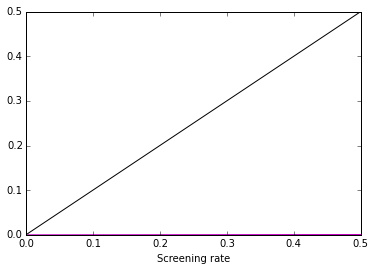

In [246]:
def plt_3obs(inc, p_symp):
    sol = test_diag_sym_asym_fun([inc, linspace(0,0.5,100), p_symp, sc_m[0], att_symp[0], p_true_pos_m[0], p_false_pos_m[0]])
    print size(sol[0])
#    fig=plt.figure()
    plt.plot(linspace(0,0.5,100), sol[0], 'k')
    plt.plot(linspace(0,0.5,100), sol[1], 'g')
    plt.plot(linspace(0,0.5,100), sol[2], 'm')
    plt.xlabel('Screening rate')
  
from IPython.html import widgets

# This should be executed in an IPython notebook!
widgets.interact(plt_3obs, inc=(0, 0.3,0.01), p_symp=(0,0.5,0.01));

expect total diagnoses 0.02 when p_ASYMP =  0.9 and incidence 0.08

Let's simulate what you would expect to observe if incidence is 0.08, screening is 0.19 and p_asymp = 0.7.

In [247]:
test_diag_sym_asym_fun([0.08, 0.19, 0.3, sc_m[0], att_symp[0], p_true_pos_m[0], p_false_pos_m[0]])


[0.21134785037286008, 0.021213219763300609, 0.0086227536823208772]

ie testing rate 0.211, symptomatic diagnoses 0.021, asymptomatic diagnoses 0.018